# ECSE 415 - Assignment 2
## Caelan Marks - 260744278

In [22]:
# Import 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Training

In [23]:
# load list of images and list of flipped images
img_list = []
img_flipped_list = []
for i in range(1, 15):
    img_list.append(cv2.cvtColor(cv2.imread("car" + str(i) + ".jpg"), cv2.COLOR_BGR2RGB))
    img_flipped_list.append(cv2.flip(img_list[i-1], 1))

In [24]:
# define function that will be used for Training part 1 & 2
def compute_hog_list(img_list):
    # Set the caell_size, block size and number of orientation bins
    cell_size = (4, 4)
    block_size = (2, 2)
    nbins = 9
    hog_feats_list = []
    
    for img in img_list:
        #1.
        # resize image 
        img = cv2.resize(img, (128, 128))
        
        #2.
        # initialize HoG descriptor
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

        # Compute the number of cells
        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

        # compute the hog features for the image and add to list 
        hog_feats_list.append(hog.compute(img) \
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[1], block_size[0], nbins) \
                   .transpose((1, 0, 3, 2, 4)))
        
    # return list of the feature maps for all the input images
    return hog_feats_list

In [25]:
# Define function that will be used for testing
# This function computers the intersection over union between two bounding boxes
def intersection_over_union(box_1, box_2):
    # boxes are of format [(X1, Y1), (X2, Y2)], the top left and bottom right corners respectively
    
    #calculate x1, y1, x2, y2 of overlapping region
    x1 = max(box_1[0][0], box_2[0][0])
    y1 = max(box_1[0][1], box_2[0][1])    
    x2 = min(box_1[1][0], box_2[1][0])    
    y2 = min(box_1[1][1], box_2[1][1]) 
    
    # return 0 if no overlapping region
    if (y2 - y1) < 0 or (x2 - x1) < 0:
        return 0

    # calculate overlapping area
    intersection_area = (y2 - y1) * (x2 - x1)
    
    # calculate area of bounding boxes
    area_box_1 = (box_1[1][0] - box_1[0][0]) * (box_1[1][1] - box_1[0][1])
    area_box_2 = (box_2[1][0] - box_2[0][0]) * (box_2[1][1] - box_2[0][1])    
    
    # retunr intersection over union
    return intersection_area / (area_box_1 + area_box_2 - intersection_area)

In [26]:
#2.
# compute the list of HoG features for the list of training images
hog_feats_list = compute_hog_list(img_list)

#3.
mean_hog = np.mean(hog_feats_list, axis=0)

#4.
# compute the list of HoG features for the list of flipped training images
hog_feats_flipped_list = compute_hog_list(img_flipped_list)

# calculate the mean HoG features of the trainin list and the flipped training list
mean_hog_flipped = np.mean(hog_feats_flipped_list, axis=0)

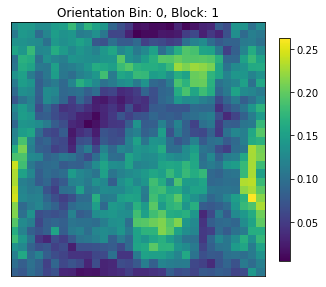

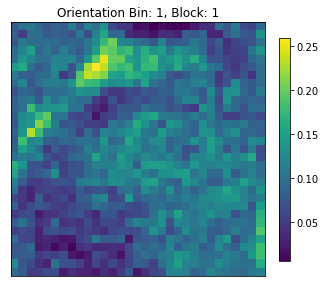

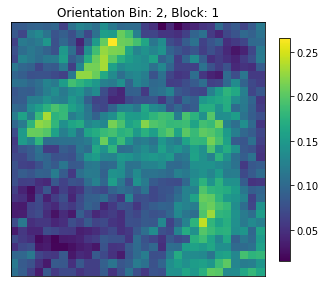

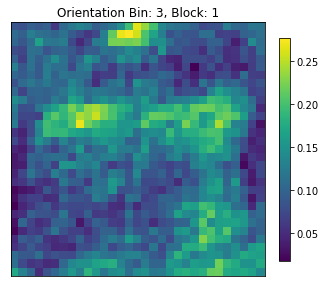

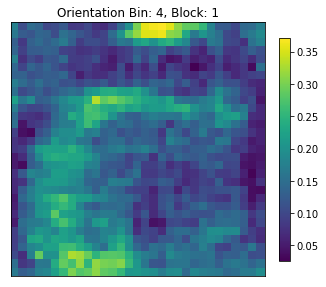

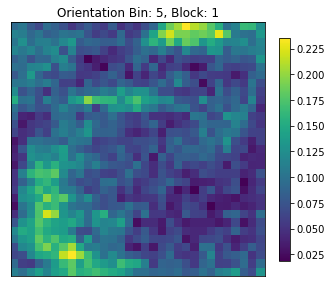

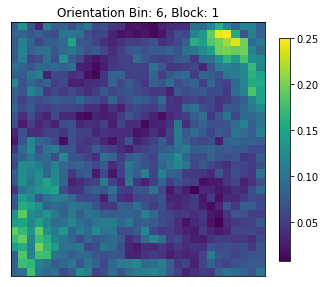

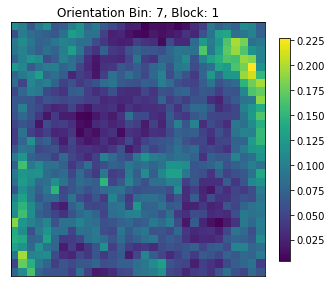

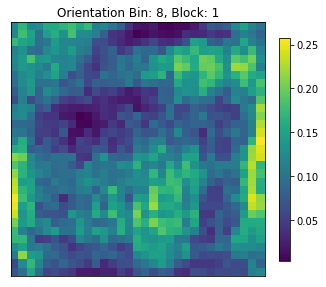

In [27]:
#5.
# Display all orientations of the mean features maps for block one
for i in range(0, 9):
    plt.figure(figsize = (5,5))
    plt.pcolor(mean_hog[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Orientation Bin: " + str(i) + ", Block: 1"), plt.xticks([]), plt.yticks([])
    plt.colorbar(fraction=0.04)
    plt.show()

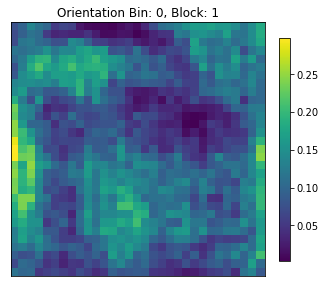

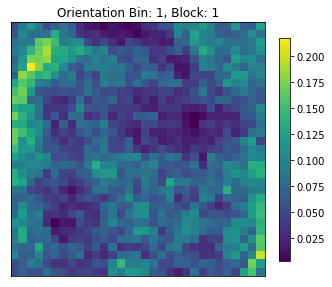

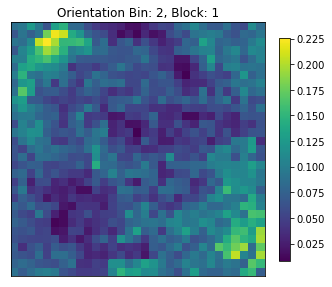

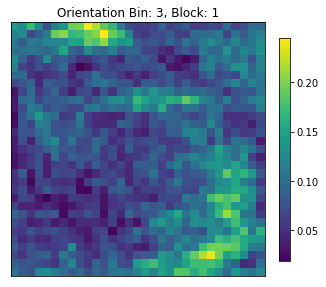

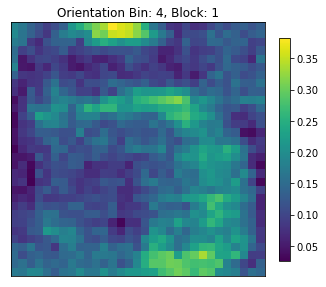

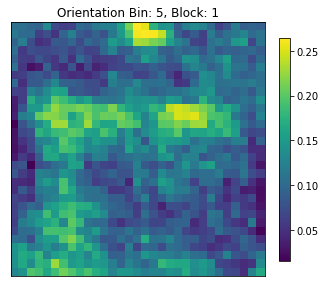

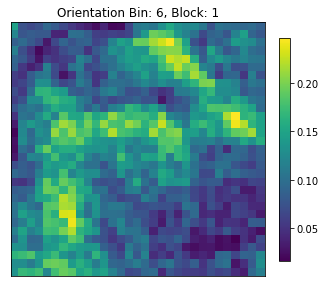

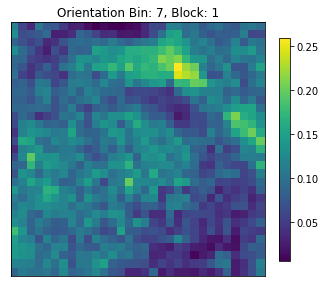

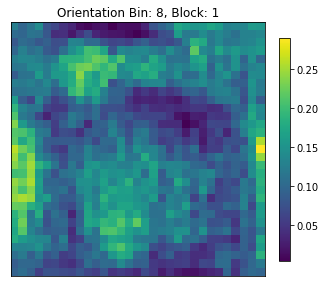

In [28]:
#5.
# Display all orientations of the mean flipped features maps for block one
for i in range(0, 9):
    plt.figure(figsize = (5,5))
    plt.pcolor(mean_hog_flipped[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Orientation Bin: " + str(i) + ", Block: 1"), plt.xticks([]), plt.yticks([])
    plt.colorbar(fraction=0.04)
    plt.show()

## Testing

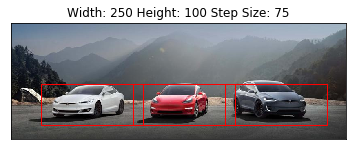

In [29]:
# Read test image and convert to RGB
img_test = cv2.imread("test.jpg")
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)


# These are the values used for the image displayed
step_size_list = [75]
window_height_list = [100]
window_width_list = [250]

#5.
# Uncomment these to test a range of values for step size, width and height as per part 5
# step_size_list = [25, 50, 75]
# window_height_list = [75, 100, 125, 150]
# window_width_list = [200, 225, 250, 275, 300]

# Loop through the testing lists to see what values are the best
# loops through step size, window width and window height
for step_size in step_size_list:
    for window_height in window_height_list:
        for window_width in window_width_list:
            
            #1.
            # Create a list of windows and window positions for the given step size, window width and window height
            window_list = []
            window_position_list = []
            for x in range(0, img_test.shape[1] - window_width, step_size):
                for y in range(0, img_test.shape[0] - window_height, step_size):
                    window_list.append(img_test[y:y + window_height, x:x + window_width,  :])
                    window_position_list.append((x, y))
            
            #2.
            # Compute the hog features maps for the windows
            hog_feats_window_list = compute_hog_list(window_list)

            #3.
            # Create a list of the distances, for each window find the distance to the original mean features map and the 
            # distance to the flipped features map, and store the distance of the smaller of the two
            distance_list = []
            for hog_feats in hog_feats_window_list:
                window_distance = 0
                window_flipped_distance = 0
                for x in range(0, 2):
                    for y in range(0, 2):
                        for orientation in range(0, 9):
                            mean = mean_hog[:, :, x, y, orientation]
                            mean_flipped = mean_hog_flipped[:, :, x, y, orientation]

                            window = hog_feats[:, :, x, y, orientation]
                            window_distance += np.sqrt(((mean - window) ** 2)).sum()
                            window_flipped_distance += np.sqrt(((mean_flipped - window) ** 2)).sum()
                if window_distance < window_flipped_distance:          
                    distance_list.append(window_distance)
                else:
                    distance_list.append(window_flipped_distance)

            #
            # I might not have had to do this, but it makes the answer nicer next section
            #
            
            # Create a combined list of the distances and their associated window positions
            distance_position_lists = zip(distance_list, window_position_list)
            
            # Sort the list of distances with the associated positions
            sorted_lists = sorted(distance_position_lists, key=lambda t: t[0])

            # Split up the list of positions and distances
            distance_list = [x for x, y in sorted_lists]
            window_position_list = [y for x, y in sorted_lists]

            # When windows are overlapping more than the intersetion over union threshold,
            # remove the smaller of the two. Do this because there is no point in displaying 
            # multiple bounding boxes over the same part of the image, especially when it is
            # known which one has the smaller distance
            iou_threshold = 0.35
            box_0 = [(-1, -1), (0, 0)]
            box_1 = [(-1, -1), (0, 0)]
            window_remove_list = []
            for window in window_position_list:
                box_2 = [(window[0], window[1]), (window[0] + window_width, window[1] + window_height)]
                iou_1 = intersection_over_union(box_0, box_2)
                iou_2 = intersection_over_union(box_1, box_2)
                if iou_1 > iou_threshold or iou_2 > iou_threshold:
                    window_remove_list.append(window)
                else:
                    box_0 = box_1
                    box_1 = box_2

            for window in window_remove_list:
                index = window_position_list.index(window)
                window_position_list.remove(window)
                del distance_list[index]
            
            #4.
            # Remove windows with a distance over the distance threshold
            distance_threshold = 3275
            distance_remove_list = []
            for distance in distance_list:
                if distance > distance_threshold:
                    distance_remove_list.append(distance)
                    
            for distance in distance_remove_list:
                index = distance_list.index(distance)
                distance_list.remove(distance)       
                del window_position_list[index]
            
            # Show the orginal image with the bounding boxes of the bounding boxes with the least distance
            fig, ax = plt.subplots(1)
            ax.imshow(img_test)
            plt.title("Width: " + str(window_width) + " Height: " + str(window_height) + " Step Size: " + str(step_size)), plt.xticks([]), plt.yticks([])

            for i in range(len(window_position_list)):
                bounding_box = patches.Rectangle((window_position_list[i][0], window_position_list[i][1]), window_width, window_height, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(bounding_box)

            plt.show()